In [ ]:
!pip install requests #Installing requests

In [ ]:
# Importing necessary libraries and modules.
import sqlite3  # For SQLite database operations.
import pandas as pd  # For data manipulation and analysis.
import urllib.request

# Summary:
# This block of code is responsible for setting up the environment to access and store files.
# It mounts Google Drive to access the sales data CSV file and to specify the location
# for creating the SQLite database file. After setting up the folder and file paths,
# it establishes a connection to the SQLite database, creating the file if it does not exist.
# It then loads the sales data from the CSV file into a pandas DataFrame and displays the
# first five rows to give an overview of the loaded data.


# URL of the raw CSV file on GitHub
csv_url = 'https://raw.githubusercontent.com/LakshmiMDas/sales-weather-impact/main/sales_data.csv'

# Read the CSV file
sales_data = pd.read_csv(csv_url)

# Display the first few rows of the dataframe
print(sales_data.head())

# URL of the SQLite database file on GitHub
db_url = 'https://github.com/LakshmiMDas/sales-weather-impact/raw/main/AIQ_db.sqlite3'

# Path where the database file will be saved locally in Colab
local_db_path = 'AIQ_db.sqlite3'

# Download the SQLite database file from GitHub to the local Colab environment
urllib.request.urlretrieve(db_url, local_db_path)

# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# For example, to list all tables in the database, you can execute the following query:
#query = "SELECT name FROM sqlite_master WHERE type='table';"
#tables = conn.execute(query).fetchall()
#print(tables)

   order_id  customer_id  product_id  quantity  price  order_date
0      2334            5          40         3  35.60  2022-06-21
1      6228            8          13         7  36.52  2023-03-08
2      7784            9          44         4  46.56  2023-04-22
3      6588            5          26         1  15.87  2022-10-23
4      5910            8          32        10  77.00  2022-10-05


In [ ]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   order_id     1000 non-null   int64  
 1   customer_id  1000 non-null   int64  
 2   product_id   1000 non-null   int64  
 3   quantity     1000 non-null   int64  
 4   price        1000 non-null   float64
 5   order_date   1000 non-null   object 
dtypes: float64(1), int64(4), object(1)
memory usage: 47.0+ KB


In [5]:
import pandas as pd
import numpy as np
import requests
import sqlite3
from datetime import datetime, timedelta

# Constants
API_KEY = "81cf91b46366d06b5347776b2dc472a6"


#Summary:
#This script is designed to fetch, process, and store weather, user, and sales data from various sources into a SQLite database.
#The weather data is fetched from the OpenWeatherMap API, user data is fetched from a placeholder API, and sales data is read from a CSV file.
#The fetched data is then processed and stored in different tables in a SQLite database.


# Fetching, transforming, and storing weather data
def get_today_weather_data(lat, lon, api_key):
    """
    Fetches the current weather data for the specified latitude and longitude using the OpenWeatherMap API.
    :param lat: Latitude of the location.
    :param lon: Longitude of the location.
    :param api_key: API Key for accessing the OpenWeatherMap API.
    :return: Returns a dictionary containing the weather data.
    """
    base_url = "https://api.openweathermap.org/data/2.5/weather"
    params = {'lat': lat, 'lon': lon, 'appid': api_key}
    response = requests.get(base_url, params=params)
    data = response.json()
    return data


def flatten(data, prefix=''):
    """
    Flattens a nested dictionary.
    :param data: The dictionary to be flattened.
    :param prefix: Prefix for the keys in the flattened dictionary.
    :return: Returns a flattened dictionary.
    """
    items = {}
    for k, v in data.items():
        if isinstance(v, dict):
            items.update(flatten(v, prefix + k + '_'))
        elif isinstance(v, list) and len(v) > 0 and isinstance(v[0], dict):
            items.update(flatten(v[0], prefix + k + '_'))
        else:
            items[prefix + k] = v
    return items


def convert_unix_to_date(unix_time):
    """
    Converts Unix timestamp to a human-readable date and time string.
    :param unix_time: The Unix timestamp to be converted.
    :return: Returns a string representing the date and time.
    """
    return datetime.utcfromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S')


def kelvin_to_celsius(temp_kelvin):
    """
    Converts temperature from Kelvin to Celsius.
    :param temp_kelvin: The temperature in Kelvin.
    :return: Returns the temperature in Celsius.
    """
    return temp_kelvin - 273.15


def temperature_simulation(day_of_year, base_data):
    """
    Simulates the daily temperature fluctuation based on the day of the year and base temperature data.
    :param day_of_year: The day of the year used for simulation.
    :param base_data: The base temperature data used for simulation.
    :return: Returns the simulated temperature.
    """
    amplitude = 5
    mean_temp = base_data['main_temp']
    temp_fluctuation = amplitude * np.sin((2 * np.pi * day_of_year) / 365)
    return mean_temp + temp_fluctuation


def create_and_store_weather_table(conn, weather_df):
    """
    Creates the 'weather' table in the database and stores the weather data in it.
    :param conn: Connection object to the SQLite database.
    :param weather_df: DataFrame containing the weather data to be stored.
    """
    # Define the schema for the 'weather' table
    weather_schema = {
        "dt": "TEXT PRIMARY KEY",
        "latitude": "TEXT",
        "longitude": "TEXT",
        "main_temp": "REAL",
        "main_temp_min": "REAL",
        "main_temp_max": "REAL",
        "main_feels_like": "REAL",
        "sys_sunrise": "TEXT",
        "sys_sunset": "TEXT",
        "weather_id": "INTEGER",
        "weather_main": "TEXT",
        "weather_description": "TEXT"
    }
    cursor = conn.cursor()
    # Drop the 'weather' table if it already exists and create a new one
    cursor.execute('DROP TABLE IF EXISTS weather')
    cursor.execute(f"CREATE TABLE weather ({', '.join([f'{col} {dtype}' for col, dtype in weather_schema.items()])})")
    # Store the weather data in the 'weather' table
    try:
        weather_df.to_sql('weather', conn, if_exists='replace', index=False)
        print("Weather data has been loaded successfully!")
    except Exception as e:
        print(f"Error storing weather data: {e}")

# Fetching, validating, and storing user data
def fetch_users_data(url="https://jsonplaceholder.typicode.com/users"):
    """
    Fetches the user data from a placeholder API.
    :param url: URL of the placeholder API.
    :return: Returns a list of dictionaries containing the user data.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        users_data = response.json()
        users_df = pd.DataFrame(users_data)
        # Extract and process the nested columns in the fetched data
        users_df['street'] = users_df['address'].apply(lambda x: x['street'])
        users_df['suite'] = users_df['address'].apply(lambda x: x['suite'])
        users_df['city'] = users_df['address'].apply(lambda x: x['city'])
        users_df['latitude'] = users_df['address'].apply(lambda x: x['geo']['lat'])
        users_df['longitude'] = users_df['address'].apply(lambda x: x['geo']['lng'])
        users_df['company_name'] = users_df['company'].apply(lambda x: x['name'])
        # Drop the original nested columns
        users_df = users_df.drop(columns=['address', 'company'])
        return users_df.to_dict(orient='records')
    except requests.RequestException as e:
        print(f"Error fetching user data: {e}")
        return None

def validate_and_store_users_data(conn, users_data):
    """
    Validates and stores the user data in the 'users' table in the database.
    :param conn: Connection object to the SQLite database.
    :param users_data: List of dictionaries containing the user data to be stored.
    """
    # Define the schema for the 'users' table
    users_schema = {
        "id": "INTEGER PRIMARY KEY",
        "name": "TEXT",
        "username": "TEXT",
        "email": "TEXT",
        "phone": "TEXT",
        "website": "TEXT",
        "street": "TEXT",
        "suite": "TEXT",
        "city": "TEXT",
        "latitude": "TEXT",
        "longitude": "TEXT",
        "company_name": "TEXT"
    }
    cursor = conn.cursor()
    # Drop the 'users' table if it already exists and create a new one
    cursor.execute('DROP TABLE IF EXISTS users')
    cursor.execute(f"CREATE TABLE users ({', '.join([f'{col} {dtype}' for col, dtype in users_schema.items()])})")
    # Store the user data in the 'users' table
    try:
        users_df = pd.DataFrame(users_data)
        for col in users_df.columns:
            if col != 'id':
                users_df[col] = users_df[col].astype(str)
        users_df.to_sql('users', conn, if_exists='replace', index=False)
        print("User data has been loaded successfully!")
    except Exception as e:
        print(f"Error storing user data: {e}")

# Fetching, validating, and storing sales data
def fetch_sales_data(file_path):
    """
    Reads the sales data from a CSV file.
    :param file_path: Path to the CSV file containing the sales data.
    :return: Returns a DataFrame containing the sales data.
    """
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError as e:
        print(f"Error loading sales data: {e}")
        return None

def validate_and_store_sales_data(conn, sales_data):
    """
    Validates and stores the sales data in the 'sales' table in the database.
    :param conn: Connection object to the SQLite database.
    :param sales_data: DataFrame containing the sales data to be stored.
    """
    # Define the schema for the 'sales' table
    sales_schema = {
        "order_id": "INTEGER PRIMARY KEY",
        "customer_id": "INTEGER",
        "product_id": "INTEGER",
        "quantity": "INTEGER",
        "price": "REAL",
        "order_date": "DATE",
        "FOREIGN KEY (customer_id)": "REFERENCES users(user_id)"
    }
    cursor = conn.cursor()
    # Drop the 'sales' table if it already exists and create a new one
    cursor.execute('DROP TABLE IF EXISTS sales')
    cursor.execute(f"CREATE TABLE sales ({', '.join([f'{col} {dtype}' for col, dtype in sales_schema.items()])})")
    # Store the sales data in the 'sales' table
    try:
        sales_data.to_sql('sales', conn, if_exists='replace', index=False)
        print("Sales data has been loaded successfully!")
    except Exception as e:
        print(f"Error storing sales data: {e}")

# Main execution method
def main():
    """
    Main execution method. Fetches, processes, and stores weather, user, and sales data.
    """

    if sales_data is not None:
        validate_and_store_sales_data(conn, sales_data)


    # Load and store user data
    users_data = fetch_users_data()
    if users_data is not None:
        validate_and_store_users_data(conn, users_data)

    # Load and store weather data
    lat = 25.076968476370983
    lon = 55.14624489140579
    today_weather_data = get_today_weather_data(lat, lon, API_KEY)
    today_weather_data['dt'] = convert_unix_to_date(today_weather_data['dt'])
    today_weather_data['sys']['sunrise'] = convert_unix_to_date(today_weather_data['sys']['sunrise'])
    today_weather_data['sys']['sunset'] = convert_unix_to_date(today_weather_data['sys']['sunset'])

    flattened_data = flatten(today_weather_data)
    base_data = pd.DataFrame([flattened_data]).iloc[0].to_dict()
    base_data['dt'] = datetime.strptime(base_data['dt'], '%Y-%m-%d %H:%M:%S')
    base_data['sys_sunrise'] = datetime.strptime(base_data['sys_sunrise'], '%Y-%m-%d %H:%M:%S')
    base_data['sys_sunset'] = datetime.strptime(base_data['sys_sunset'], '%Y-%m-%d %H:%M:%S')

    base_data['main_temp'] = kelvin_to_celsius(base_data['main_temp'])
    base_data['main_temp_min'] = kelvin_to_celsius(base_data['main_temp_min'])
    base_data['main_temp_max'] = kelvin_to_celsius(base_data['main_temp_max'])
    base_data['main_feels_like'] = kelvin_to_celsius(base_data['main_feels_like'])

    start_date = datetime(2022, 6, 1)
    end_date = datetime(2023, 6, 2)
    date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days)]

    sample_data = []
    for date in date_range:
        entry = base_data.copy()
        day_of_year = date.timetuple().tm_yday

        temp = temperature_simulation(day_of_year, base_data)
        entry['main_temp'] = temp
        entry['main_temp_min'] = temp - np.random.uniform(1, 3)
        entry['main_temp_max'] = temp + np.random.uniform(1, 3)
        entry['main_feels_like'] = temp + np.random.uniform(-2, 2)

        sunrise_shift = timedelta(minutes=int(120 * np.sin((2 * np.pi * day_of_year) / 365)))
        sunset_shift = -sunrise_shift
        entry['sys_sunrise'] = entry['sys_sunrise'] + sunrise_shift
        entry['sys_sunset'] = entry['sys_sunset'] + sunset_shift

        entry['dt'] = date + (entry['dt'] - datetime(entry['dt'].year, entry['dt'].month, entry['dt'].day))

        if np.random.random() < 0.1:
            entry['weather_id'] = np.random.choice([800, 801, 802, 803, 804])
            weather_mapping = {
                800: ("Clear", "clear sky"),
                801: ("Clouds", "few clouds"),
                802: ("Clouds", "scattered clouds"),
                803: ("Clouds", "broken clouds"),
                804: ("Clouds", "overcast clouds"),
            }
            entry['weather_main'], entry['weather_description'] = weather_mapping[entry['weather_id']]

        sample_data.append(entry)

    weather_df = pd.DataFrame(sample_data)
    create_and_store_weather_table(conn, weather_df)

    # Display counts and samples from the loaded tables
    cursor = conn.cursor()
    users_count = cursor.execute("SELECT COUNT(*) FROM users;").fetchone()[0]
    sales_count = cursor.execute("SELECT COUNT(*) FROM sales;").fetchone()[0]
    weather_count = cursor.execute("SELECT COUNT(*) FROM weather;").fetchone()[0]

    print(f"\nTotal Users Loaded: {users_count}")
    print(f"Total Sales Loaded: {sales_count}")
    print(f"Total Weather Data Loaded: {weather_count}")

    user_data_sample = cursor.execute("SELECT * FROM users LIMIT 1;").fetchone()
    sales_data_sample = cursor.execute("SELECT * FROM sales LIMIT 1;").fetchone()
    weather_data_sample = cursor.execute("SELECT * FROM weather LIMIT 1;").fetchone()

    print("\nSample User Data:", user_data_sample)
    print("Sample Sales Data:", sales_data_sample)
    print("Sample Weather Data:", weather_data_sample)

    conn.close()

if __name__ == "__main__":
    main()

Sales data has been loaded successfully!
User data has been loaded successfully!
Weather data has been loaded successfully!

Total Users Loaded: 10
Total Sales Loaded: 1000
Total Weather Data Loaded: 366

Sample User Data: (1, 'Leanne Graham', 'Bret', 'Sincere@april.biz', '1-770-736-8031 x56442', 'hildegard.org', 'Kulas Light', 'Apt. 556', 'Gwenborough', '-37.3159', '81.1496', 'Romaguera-Crona')
Sample Sales Data: (2334, 5, 40, 3, 35.6, '2022-06-21')
Sample Weather Data: (55.1462, 25.077, 800, 'Clear', 'clear sky', '01d', 'stations', 43.77620906722892, 45.04151758506956, 40.781845582198166, 45.90419701786912, 1003, 47, 1003, 1003, 10000, 5.59, 299, 5.14, 0, '2022-06-01 10:46:08', 1, 7539, 'AE', '2023-09-25 03:08:53', '2023-09-25 13:13:42', 14400, 292224, 'Dubai', 200)


In [6]:
"""
This script retrieves user data from a public API and processes the retrieved data.
It splits nested columns into multiple columns to flatten the structure and make the data easily understandable and usable.
The processed data is stored in a DataFrame and displayed.

"""

import requests
import pandas as pd  # Importing the pandas library as it's used in processing the DataFrame.

# Sending a GET request to the API endpoint to retrieve user data.
response = requests.get("https://jsonplaceholder.typicode.com/users")
users_data = response.json()  # Converting the JSON response to a Python object.

# Converting the user data to a DataFrame for further processing.
users_df = pd.DataFrame(users_data)

# Processing the 'address' nested column and creating separate columns for each nested attribute.
users_df['street'] = users_df['address'].apply(lambda x: x['street'])
users_df['suite'] = users_df['address'].apply(lambda x: x['suite'])
users_df['city'] = users_df['address'].apply(lambda x: x['city'])
users_df['latitude'] = users_df['address'].apply(lambda x: x['geo']['lat'])  # Extracting latitude from the 'geo' nested attribute.
users_df['longitude'] = users_df['address'].apply(lambda x: x['geo']['lng'])  # Extracting longitude from the 'geo' nested attribute.

# Extracting the 'name' attribute from the 'company' nested column.
users_df['company_name'] = users_df['company'].apply(lambda x: x['name'])

# Dropping the original nested columns ('address' and 'company') as they are no longer needed.
users_df = users_df.drop(columns=['address', 'company'])

# Displaying the first few rows of the processed DataFrame to visualize the final structure of the data.
users_df.head(20)

,id,name,username,email,phone,website,street,suite,city,latitude,longitude,company_name
0,1,Leanne Graham,Bret,Sincere@april.biz,1-770-736-8031 x56442,hildegard.org,Kulas Light,Apt. 556,Gwenborough,-37.3159,81.1496,Romaguera-Crona
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,010-692-6593 x09125,anastasia.net,Victor Plains,Suite 879,Wisokyburgh,-43.9509,-34.4618,Deckow-Crist
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,1-463-123-4447,ramiro.info,Douglas Extension,Suite 847,McKenziehaven,-68.6102,-47.0653,Romaguera-Jacobson
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,493-170-9623 x156,kale.biz,Hoeger Mall,Apt. 692,South Elvis,29.4572,-164.2990,Robel-Corkery
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,(254)954-1289,demarco.info,Skiles Walks,Suite 351,Roscoeview,-31.8129,62.5342,Keebler LLC
5,6,Mrs. Dennis Schulist,Leopoldo_Corkery,Karley_Dach@jasper.info,1-477-935-8478 x6430,ola.org,Norberto Crossing,Apt. 950,South Christy,-71.4197,71.7478,Considine-Lockman
6,7,Kurtis Weissnat,Elwyn.Skiles,Telly.Hoeger@billy.biz,210.067.6132,elvis.io,Rex Trail,Suite 280,Howemouth,24.8918,21.8984,Johns Group
7,8,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,586.493.6943 x140,jacynthe.com,Ellsworth Summit,Suite 729,Aliyaview,-14.3990,-120.7677,Abernathy Group
8,9,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,(775)976-6794 x41206,conrad.com,Dayna Park,Suite 449,Bartholomebury,24.6463,-168.8889,Yost and Sons
9,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,024-648-3804,ambrose.net,Kattie Turnpike,Suite 198,Lebsackbury,-38.2386,57.2232,Hoeger LLC


In [7]:
"""
This script connects to a SQLite database, retrieves samples of data from three different tables (users, sales, weather),
and displays the retrieved data. It fetches and displays 5 rows from each table as a sample.

"""

import sqlite3  # Importing the sqlite3 library as it's used to interact with the SQLite database.


# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# Creating a cursor object to execute SQL queries.
cursor = conn.cursor()


# Fetching and displaying 5 rows from the 'users' table as a sample.
user_data_sample = cursor.execute("SELECT * FROM users LIMIT 5;").fetchmany(5)
print("User Data Sample:")
for row in user_data_sample:
    print(row)  # Printing each row of the fetched user data.

# Fetching and displaying 5 rows from the 'sales' table as a sample.
sales_data_sample = cursor.execute("SELECT * FROM sales LIMIT 5;").fetchmany(5)
print("\nSales Data Sample:")
for row in sales_data_sample:
    print(row)  # Printing each row of the fetched sales data.

# Fetching and displaying 5 rows from the 'weather' table as a sample.
weather_data_sample = cursor.execute("SELECT * FROM weather LIMIT 5;").fetchmany(5)
print("\nWeather Data Sample:")
for row in weather_data_sample:
    print(row)  # Printing each row of the fetched weather data.

# Closing the database connection after all operations are completed to release resources.
conn.close()

User Data Sample:
(1, 'Leanne Graham', 'Bret', 'Sincere@april.biz', '1-770-736-8031 x56442', 'hildegard.org', 'Kulas Light', 'Apt. 556', 'Gwenborough', '-37.3159', '81.1496', 'Romaguera-Crona')
(2, 'Ervin Howell', 'Antonette', 'Shanna@melissa.tv', '010-692-6593 x09125', 'anastasia.net', 'Victor Plains', 'Suite 879', 'Wisokyburgh', '-43.9509', '-34.4618', 'Deckow-Crist')
(3, 'Clementine Bauch', 'Samantha', 'Nathan@yesenia.net', '1-463-123-4447', 'ramiro.info', 'Douglas Extension', 'Suite 847', 'McKenziehaven', '-68.6102', '-47.0653', 'Romaguera-Jacobson')
(4, 'Patricia Lebsack', 'Karianne', 'Julianne.OConner@kory.org', '493-170-9623 x156', 'kale.biz', 'Hoeger Mall', 'Apt. 692', 'South Elvis', '29.4572', '-164.2990', 'Robel-Corkery')
(5, 'Chelsey Dietrich', 'Kamren', 'Lucio_Hettinger@annie.ca', '(254)954-1289', 'demarco.info', 'Skiles Walks', 'Suite 351', 'Roscoeview', '-31.8129', '62.5342', 'Keebler LLC')

Sales Data Sample:
(2334, 5, 40, 3, 35.6, '2022-06-21')
(6228, 8, 13, 7, 36.52, '

In [ ]:
"""
This script establishes a connection to a SQLite database and retrieves the schema information of three specified tables
(users, sales, weather), displaying the name and type of each column in these tables. This script is useful for understanding
the structure of the tables in the database.

"""

import sqlite3  # Importing the sqlite3 library to interact with SQLite databases.


# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# Creating a cursor object to execute SQL queries.
cursor = conn.cursor()

def describe_table(table_name):
    """
    This function fetches and prints the column names and types for a specified table.
    :param table_name: Name of the table whose structure is to be described.
    """
    print(f"\n{table_name} Table Columns:")  # Printing the table name.
    cursor.execute(f"PRAGMA table_info({table_name});")  # Executing SQL command to fetch table structure.
    for row in cursor.fetchall():
        print(f"{row[1]}: {row[2]}")  # Printing each column's name and type. row[1] is column name, row[2] is column type.

# Describing the structures of 'users', 'sales', and 'weather' tables by calling the describe_table function.
describe_table('users')
describe_table('sales')
describe_table('weather')

# Closing the database connection after all operations are completed to release resources.
conn.close()


users Table Columns:
id: INTEGER
name: TEXT
username: TEXT
email: TEXT
phone: TEXT
website: TEXT
street: TEXT
suite: TEXT
city: TEXT
latitude: TEXT
longitude: TEXT
company_name: TEXT

sales Table Columns:
order_id: INTEGER
customer_id: INTEGER
product_id: INTEGER
quantity: INTEGER
price: REAL
order_date: TEXT

weather Table Columns:
coord_lon: REAL
coord_lat: REAL
weather_id: INTEGER
weather_main: TEXT
weather_description: TEXT
weather_icon: TEXT
base: TEXT
main_temp: REAL
main_feels_like: REAL
main_temp_min: REAL
main_temp_max: REAL
main_pressure: INTEGER
main_humidity: INTEGER
main_sea_level: INTEGER
main_grnd_level: INTEGER
visibility: INTEGER
wind_speed: REAL
wind_deg: INTEGER
wind_gust: REAL
clouds_all: INTEGER
dt: TIMESTAMP
sys_type: INTEGER
sys_id: INTEGER
sys_country: TEXT
sys_sunrise: TIMESTAMP
sys_sunset: TIMESTAMP
timezone: INTEGER
id: INTEGER
name: TEXT
cod: INTEGER


In [ ]:
"""
This script performs the following operations on a SQLite database:
1. Establishes a connection to the database.
2. Drops the 'merged_table' if it already exists.
3. Creates a new 'merged_table' by merging the 'sales', 'users', and 'weather' tables based on relevant keys.
4. Commits the transaction to save the changes made to the database.
5. Closes the connection to the database.

Summary:
- The 'sales' table is merged with 'users' on 'customer_id' and 'id' respectively.
- The resulting table is then merged with 'weather' on the dates of 'order_date' and 'dt'.
- The final 'merged_table' contains selected columns from all three tables, providing a comprehensive view of the data.
"""

import sqlite3  # Importing sqlite3 module to interact with SQLite databases.
from datetime import datetime  # Importing datetime for any date manipulations, if needed.


# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# Creating a cursor object to execute SQL queries.
cursor = conn.cursor()

# Dropping the 'merged_table' if it already exists to avoid conflicts.
cursor.execute('DROP TABLE IF EXISTS merged_table')

# Creating a new 'merged_table' by performing left outer joins on 'sales', 'users', and 'weather' tables.
# This table will contain selected columns from all three tables, merged based on 'customer_id', 'id', and 'order_date' columns.
cursor.execute('''CREATE TABLE merged_table AS
SELECT
    s.order_id,
    s.customer_id,
    s.product_id,
    s.quantity,
    s.price,
    s.order_date,
    w.main_temp,
    w.main_feels_like,
    w.weather_main,
    w.weather_description,
    w.wind_speed,
    u.id,
    u.name,
    u.username,
    u.email,
    u.phone,
    u.website,
    u.street,
    u.suite,
    u.city,
    u.latitude,
    u.longitude,
    u.company_name
FROM sales s
LEFT OUTER JOIN users u ON s.customer_id = u.id
LEFT OUTER JOIN weather w ON DATE(s.order_date) = DATE(w.dt)
''')

# Committing the transaction to save the changes made to the database.
conn.commit()

# Closing the database connection after all operations are completed to release resources.
conn.close()

In [ ]:
"""
This script performs the following operations with a SQLite database:
1. Establishes a connection to the specified database.
2. Retrieves and prints the count of rows in the 'merged_table'.
3. Retrieves and prints the first 20 rows from the 'merged_table'.
4. Closes the connection to the database after the operations are completed.

Summary:
- The script is useful to quickly verify the contents of 'merged_table' and ensure that the data has been merged correctly.
- It displays the count of rows to confirm the total number of records and prints the first 20 rows to give a snapshot of the data in 'merged_table'.
"""

import sqlite3  # Importing sqlite3 module to interact with SQLite databases.


# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# Creating a cursor object to execute SQL queries.
cursor = conn.cursor()

# Retrieving and printing the count of rows in 'merged_table'.
count = cursor.execute("SELECT COUNT(*) FROM merged_table;").fetchone()[0]
print(f"Count of rows in merged_table: {count}")

# Retrieving the first 20 rows from 'merged_table'.
rows = cursor.execute("SELECT * FROM merged_table LIMIT 20;").fetchall()

# Displaying the retrieved rows to get a quick snapshot of the data in 'merged_table'.
print("\nFirst 20 rows in merged_table:")
for row in rows:
    print(row)

# Closing the database connection to release the resources.
conn.close()

Count of rows in merged_table: 1000

First 20 rows in merged_table:
(2334, 5, 40, 3, 35.6, '2022-06-21', 42.16883292862785, 42.97189861985299, 'Clear', 'clear sky', 4.57, 5, 'Chelsey Dietrich', 'Kamren', 'Lucio_Hettinger@annie.ca', '(254)954-1289', 'demarco.info', 'Skiles Walks', 'Suite 351', 'Roscoeview', '-31.8129', '62.5342', 'Keebler LLC')
(6228, 8, 13, 7, 36.52, '2023-03-08', 45.84063994092671, 46.92417647217659, 'Clear', 'clear sky', 4.57, 8, 'Nicholas Runolfsdottir V', 'Maxime_Nienow', 'Sherwood@rosamond.me', '586.493.6943 x140', 'jacynthe.com', 'Ellsworth Summit', 'Suite 729', 'Aliyaview', '-14.3990', '-120.7677', 'Abernathy Group')
(7784, 9, 44, 4, 46.56, '2023-04-22', 45.95440673147719, 45.5616937136529, 'Clear', 'clear sky', 4.57, 9, 'Glenna Reichert', 'Delphine', 'Chaim_McDermott@dana.io', '(775)976-6794 x41206', 'conrad.com', 'Dayna Park', 'Suite 449', 'Bartholomebury', '24.6463', '-168.8889', 'Yost and Sons')
(6588, 5, 26, 1, 15.87, '2022-10-23', 36.63229158210406, 37.517

In [ ]:
"""
This script performs the following operations with a SQLite database:
1. Establishes a connection to the specified database.
2. Executes a SQL query to calculate the average sales amount for each unique weather description present in the 'weather' table.
3. Retrieves and prints the results of the query, displaying the average sales amount per weather description.
4. Closes the connection to the database after the operations are completed.

Summary:
- The script provides insights into how different detailed weather descriptions might be affecting sales by computing the average sales amount associated with each weather description.
- It correlates sales data with detailed weather data to derive meaningful insights which can be useful for analysis and decision-making.
"""

import sqlite3  # Importing sqlite3 module to interact with SQLite databases.

# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# Creating a cursor object to execute SQL queries.
cursor = conn.cursor()

# Define the SQL query to calculate the average sales amount for each unique weather description.
query = """
SELECT
    w.weather_description,
    AVG(s.price * s.quantity) AS avg_sales_amount
FROM sales s
LEFT JOIN weather w ON DATE(s.order_date) = DATE(w.dt)
GROUP BY w.weather_description;
"""

# Executing the query and fetching the results.
rows = cursor.execute(query).fetchall()

# Displaying the retrieved rows to visualize the average sales amount per weather description.
print("Average Sales Amount per Weather Description:")
for row in rows:
    print(row)

# Closing the database connection to release the resources.
conn.close()

Average Sales Amount per Weather Description:
('broken clouds', 308.09625)
('clear sky', 305.87713651498336)
('few clouds', 333.1283333333334)
('overcast clouds', 380.602380952381)
('scattered clouds', 349.95)


In [ ]:
import requests

response = requests.get("https://jsonplaceholder.typicode.com/users")
users_data = response.json()
users_df = pd.DataFrame(users_data)

# Splitting the address column into separate columns
users_df['street'] = users_df['address'].apply(lambda x: x['street'])
users_df['suite'] = users_df['address'].apply(lambda x: x['suite'])
users_df['city'] = users_df['address'].apply(lambda x: x['city'])
users_df['latitude'] = users_df['address'].apply(lambda x: x['geo']['lat'])
users_df['longitude'] = users_df['address'].apply(lambda x: x['geo']['lng'])

# Extracting the company name from the company column
users_df['company_name'] = users_df['company'].apply(lambda x: x['name'])

# Dropping the original address and company columns
users_df = users_df.drop(columns=['address', 'company'])

# Displaying the first few rows of the updated DataFrame
users_df.head(20)

,id,name,username,email,phone,website,street,suite,city,latitude,longitude,company_name
0,1,Leanne Graham,Bret,Sincere@april.biz,1-770-736-8031 x56442,hildegard.org,Kulas Light,Apt. 556,Gwenborough,-37.3159,81.1496,Romaguera-Crona
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,010-692-6593 x09125,anastasia.net,Victor Plains,Suite 879,Wisokyburgh,-43.9509,-34.4618,Deckow-Crist
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,1-463-123-4447,ramiro.info,Douglas Extension,Suite 847,McKenziehaven,-68.6102,-47.0653,Romaguera-Jacobson
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,493-170-9623 x156,kale.biz,Hoeger Mall,Apt. 692,South Elvis,29.4572,-164.2990,Robel-Corkery
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,(254)954-1289,demarco.info,Skiles Walks,Suite 351,Roscoeview,-31.8129,62.5342,Keebler LLC
5,6,Mrs. Dennis Schulist,Leopoldo_Corkery,Karley_Dach@jasper.info,1-477-935-8478 x6430,ola.org,Norberto Crossing,Apt. 950,South Christy,-71.4197,71.7478,Considine-Lockman
6,7,Kurtis Weissnat,Elwyn.Skiles,Telly.Hoeger@billy.biz,210.067.6132,elvis.io,Rex Trail,Suite 280,Howemouth,24.8918,21.8984,Johns Group
7,8,Nicholas Runolfsdottir V,Maxime_Nienow,Sherwood@rosamond.me,586.493.6943 x140,jacynthe.com,Ellsworth Summit,Suite 729,Aliyaview,-14.3990,-120.7677,Abernathy Group
8,9,Glenna Reichert,Delphine,Chaim_McDermott@dana.io,(775)976-6794 x41206,conrad.com,Dayna Park,Suite 449,Bartholomebury,24.6463,-168.8889,Yost and Sons
9,10,Clementina DuBuque,Moriah.Stanton,Rey.Padberg@karina.biz,024-648-3804,ambrose.net,Kattie Turnpike,Suite 198,Lebsackbury,-38.2386,57.2232,Hoeger LLC


In [ ]:
import pandas as pd

# Select distinct customer_id and order_date from sales_data
distinct_sales = sales_data.drop_duplicates()

# Select distinct id, name, city, latitude, and longitude from users_df
distinct_users = users_df[['id', 'name', 'city', 'latitude', 'longitude']].drop_duplicates()

# Join the two dataframes on customer_id & id
result_df = pd.merge(distinct_sales, distinct_users, left_on='customer_id', right_on='id').drop('id', axis=1)

result_df.head()

,order_id,customer_id,product_id,quantity,price,order_date,name,city,latitude,longitude
0,2334,5,40,3,35.60,2022-06-21,Chelsey Dietrich,Roscoeview,-31.8129,62.5342
1,6588,5,26,1,15.87,2022-10-23,Chelsey Dietrich,Roscoeview,-31.8129,62.5342
2,3569,5,47,9,19.35,2023-05-25,Chelsey Dietrich,Roscoeview,-31.8129,62.5342
3,5200,5,50,6,82.12,2023-02-28,Chelsey Dietrich,Roscoeview,-31.8129,62.5342
4,1589,5,10,1,96.94,2023-01-05,Chelsey Dietrich,Roscoeview,-31.8129,62.5342


In [ ]:
"""
This script analyzes a DataFrame named `result_df` containing sales data and performs the following tasks:
1. It calculates the total sales amount per customer and stores the result in a new DataFrame.
2. It determines the average order quantity per product and stores the result in a new DataFrame.
3. It identifies the top-selling products and top customers by sales amount and stores the results in new DataFrames.
4. It analyzes sales trends over time, specifically on a monthly basis, and stores the result in a new DataFrame.
5. Finally, it prints the results of each of the analysis tasks to the console.

Summary:
- The script provides insights into customer behavior, product performance, and sales trends.
- It calculates metrics such as total sales per customer, average order quantity per product, top-selling products, top customers by sales amount, and monthly sales trends.
"""

import pandas as pd  # Importing pandas for data manipulation and analysis.

# Assuming result_df is a DataFrame with appropriate sales data.

# 1. Calculate total sales amount per customer
# Creating a new column 'sales_amount' in result_df to store the product of quantity and price for each row.
result_df['sales_amount'] = result_df['quantity'] * result_df['price']
# Grouping the DataFrame by 'customer_id' and summing the 'sales_amount' for each group.
total_sales_per_customer = result_df.groupby('customer_id')['sales_amount'].sum().reset_index()

# 2. Determine the average order quantity per product
# Grouping the DataFrame by 'product_id' and calculating the mean of 'quantity' for each group.
avg_order_quantity_per_product = result_df.groupby('product_id')['quantity'].mean().reset_index()

# 3. Identify the top-selling products or customers
# Calculating top-selling products by grouping by 'product_id' and summing the 'quantity', then sorting the results.
top_selling_products = result_df.groupby('product_id')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False).head()

# Calculating top customers by sales amount by sorting the total_sales_per_customer DataFrame.
top_customers_by_sales = total_sales_per_customer.sort_values(by='sales_amount', ascending=False).head()

# 4. Analyze sales trends over time
# Converting the 'order_date' column to datetime format for time-based grouping.
result_df['order_date'] = pd.to_datetime(result_df['order_date'])
# Resampling the DataFrame on a monthly basis and summing the 'sales_amount' for each month.
monthly_sales = result_df.resample('M', on='order_date').sum()['sales_amount'].reset_index()

# Displaying the results of the analysis tasks.
print("Total Sales Per Customer:\n", total_sales_per_customer)
print("\nAverage Order Quantity Per Product:\n", avg_order_quantity_per_product)
print("\nTop Selling Products:\n", top_selling_products)
print("\nTop Customers by Sales Amount:\n", top_customers_by_sales)
print("\nMonthly Sales Trends:\n", monthly_sales)

Total Sales Per Customer:
    customer_id  sales_amount
0            1      24680.98
1            2      33147.26
2            3      31018.80
3            4      28625.48
4            5      31156.73
5            6      30168.84
6            7      28737.81
7            8      31860.25
8            9      33040.69
9           10      36704.17

Average Order Quantity Per Product:
     product_id  quantity
0            1  5.000000
1            2  5.916667
2            3  6.307692
3            4  6.750000
4            5  5.000000
5            6  5.461538
6            7  4.866667
7            8  6.222222
8            9  5.133333
9           10  4.954545
10          11  5.027778
11          12  6.350000
12          13  6.090909
13          14  7.187500
14          15  5.500000
15          16  5.200000
16          17  5.555556
17          18  6.000000
18          19  6.227273
19          20  6.000000
20          21  4.888889
21          22  5.461538
22          23  5.571429
23          24  

<ipython-input-184-227cee098b05>:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sales = result_df.resample('M', on='order_date').sum()['sales_amount'].reset_index()


##Exploratory Data Analysis

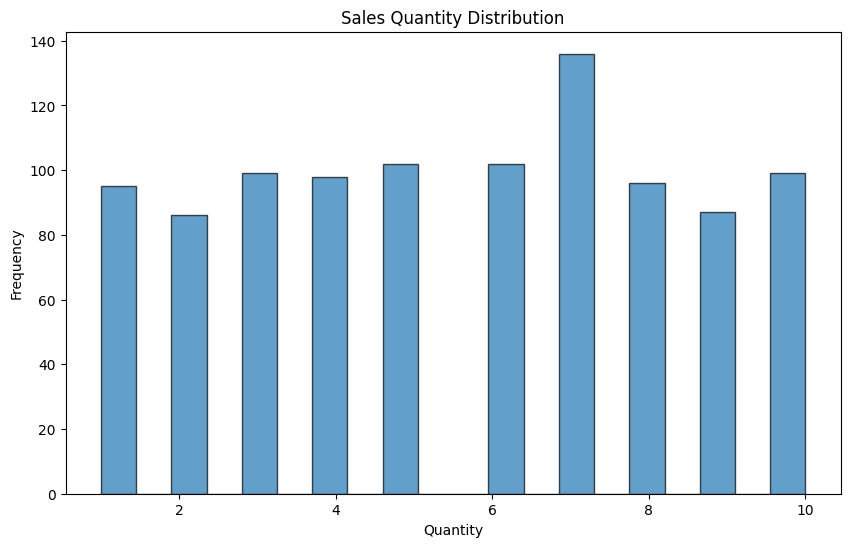

In [ ]:
# This histogram illustrates the distribution of sales quantities, highlighting common values and potential outliers.

plt.figure(figsize=(10,6))
plt.hist(sales_data['quantity'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Sales Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()


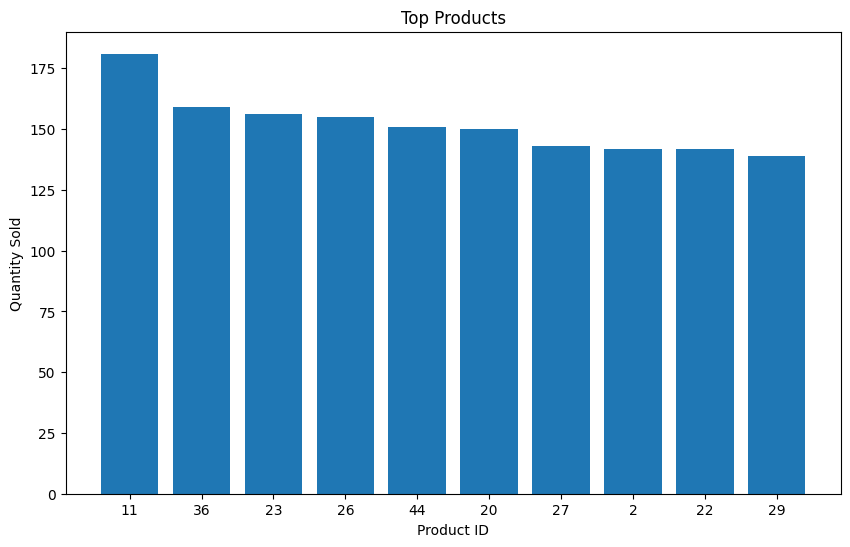

In [ ]:
# This bar chart displays the top 10 products by quantity sold, allowing a quick comparison of product performance.

# Grouping by product_id and summing the quantities
top_products = sales_data.groupby('product_id')['quantity'].sum().reset_index()

# Sorting the products by quantity in descending order and taking the top N products
top_products = top_products.sort_values(by='quantity', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_products['product_id'].astype(str), top_products['quantity'])
plt.title('Top Products')
plt.xlabel('Product ID')
plt.ylabel('Quantity Sold')
plt.show()


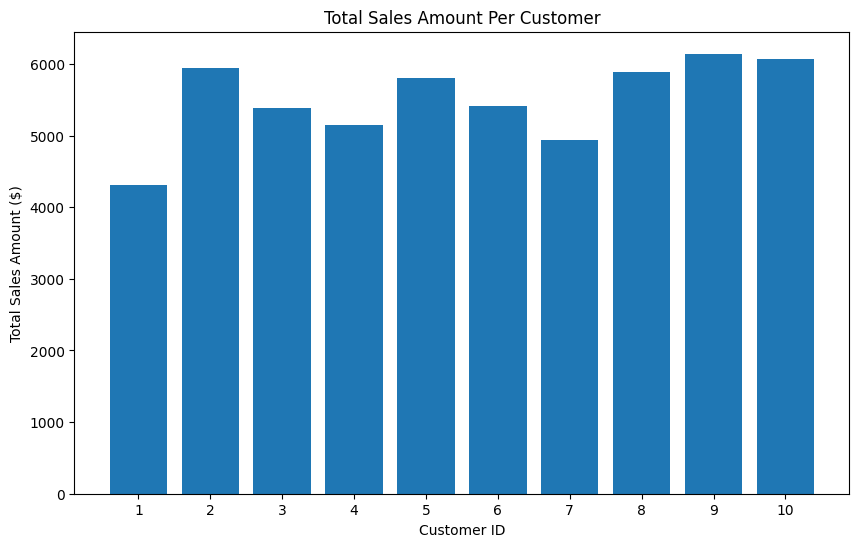

In [ ]:
# This bar chart presents the total sales amount per customer, enabling a swift evaluation of customer value.

customer_sales = sales_data.groupby('customer_id')['price'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(customer_sales['customer_id'].astype(str), customer_sales['price'])
plt.title('Total Sales Amount Per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Total Sales Amount ($)')
plt.show()


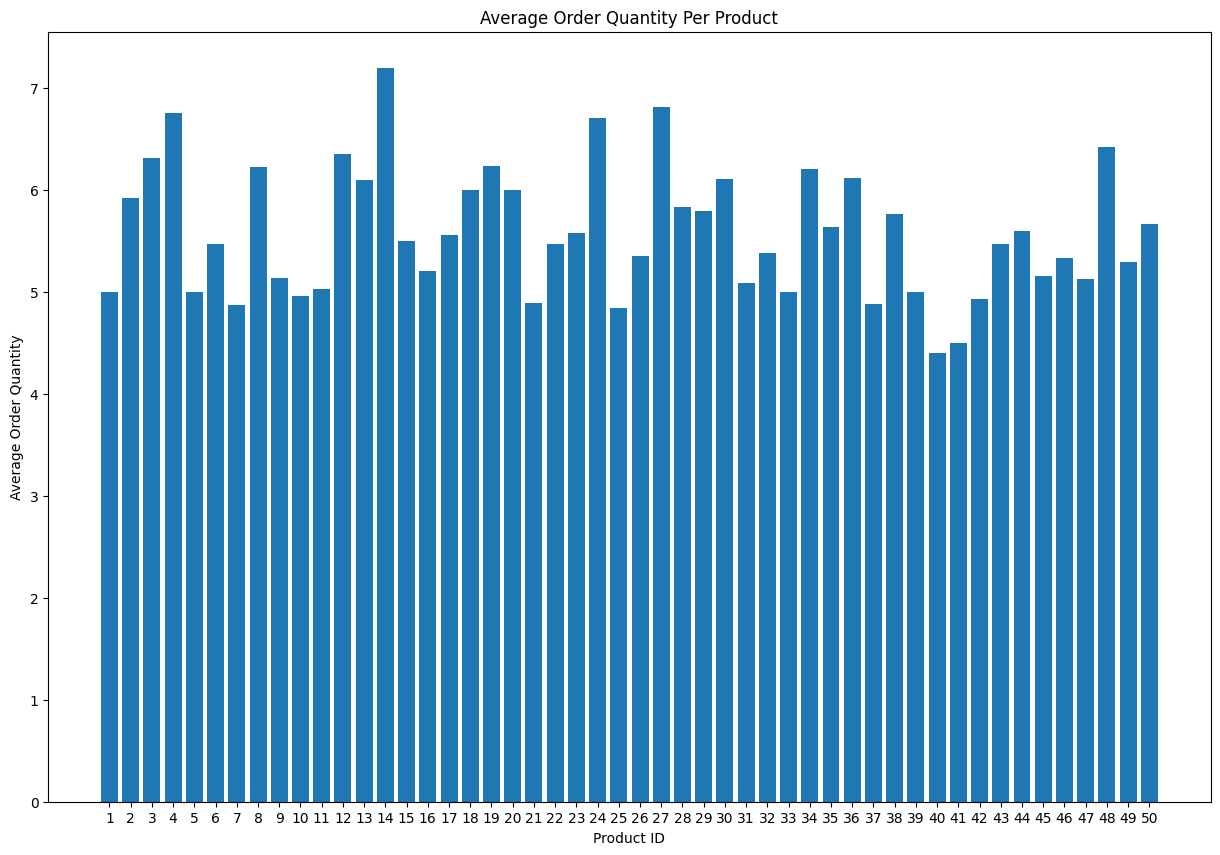

In [ ]:
# This bar chart depicts the average order quantity for each product, facilitating a clear insight into product preference and demand.

product_order_avg = sales_data.groupby('product_id')['quantity'].mean().reset_index()
plt.figure(figsize=(15,10))
plt.bar(product_order_avg['product_id'].astype(str), product_order_avg['quantity'])
plt.title('Average Order Quantity Per Product')
plt.xlabel('Product ID')
plt.ylabel('Average Order Quantity')
plt.show()


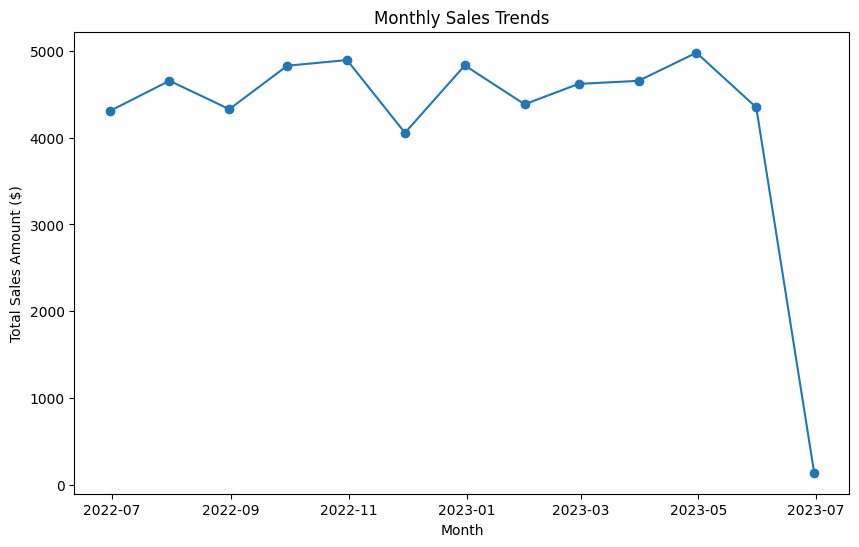

In [ ]:
# This line chart illustrates the monthly sales trends, providing insights into the sales pattern and fluctuations over time.

sales_data['order_date'] = pd.to_datetime(sales_data['order_date'])
monthly_sales = sales_data.resample('M', on='order_date')['price'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.plot(monthly_sales['order_date'], monthly_sales['price'], marker='o')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount ($)')
plt.show()


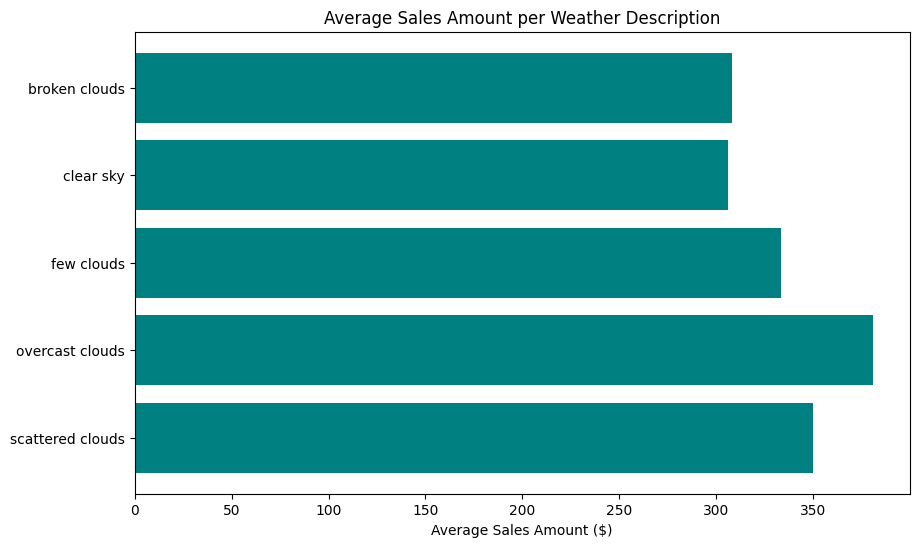

In [ ]:
"""
This script performs the following operations with a SQLite database:
1. Establishes a connection to the specified database.
2. Executes a SQL query to calculate the average sales amount for each unique weather description present in the 'weather' table.
3. Retrieves the results of the query, displaying the average sales amount per weather description.
4. Visualizes the average sales amount per weather description using a bar chart.
5. Closes the connection to the database after the operations are completed.

Summary:
- The script provides insights into how different detailed weather descriptions might be affecting sales by computing and visualizing the average sales amount associated with each weather description.
- It correlates sales data with detailed weather data to derive meaningful insights which can be useful for analysis and decision-making.
"""

import sqlite3  # Importing sqlite3 module to interact with SQLite databases.
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for data visualization.

# Connect to the SQLite database
conn = sqlite3.connect(local_db_path)

# Creating a cursor object to execute SQL queries.
cursor = conn.cursor()

# Define the SQL query to calculate the average sales amount for each unique weather description.
query = """
SELECT
    w.weather_description,
    AVG(s.price * s.quantity) AS avg_sales_amount
FROM sales s
LEFT JOIN weather w ON DATE(s.order_date) = DATE(w.dt)
GROUP BY w.weather_description;
"""

# Executing the query and fetching the results.
rows = cursor.execute(query).fetchall()

# Check if any rows were returned, and visualize them.
if rows:
    # Extracting descriptions and average sales amounts for plotting
    descriptions = [row[0] for row in rows]
    avg_sales = [row[1] for row in rows]

    # Creating the bar chart
    plt.figure(figsize=(10,6))
    plt.barh(descriptions, avg_sales, color='teal')
    plt.xlabel('Average Sales Amount ($)')
    plt.title('Average Sales Amount per Weather Description')
    plt.gca().invert_yaxis()  # To display the highest bar at the top
    plt.show()
else:
    print("No results found.")

# Closing the database connection to release the resources.
conn.close()
